# PCA-Based Composite Scores for Squad Analytics

## Overview
This notebook explores using **Principal Component Analysis (PCA)** to create data-driven composite scores for Premier League squad statistics, replacing simple equal-weight averaging with unsupervised learning.

### Why PCA for Composite Scores?
- **Equal weighting assumes all metrics are equally important** - PCA learns importance from data
- **Reduces multicollinearity** - Combines correlated metrics intelligently
- **Captures variance structure** - Weights metrics by how much they explain squad differences
- **Data-driven** - Let the patterns in the data determine the weights

### Approach
1. **Per-Category PCA**: Apply PCA separately to each of 7 stat categories
2. **Weighted Components**: Use top PCs weighted by explained variance
3. **Comparison**: Compare PCA scores vs equal-weight scores
4. **Insights**: Understand which metrics contribute most via loadings

### Learning Objectives
- Understand PCA theory and application
- Implement PCA for feature engineering in sports analytics
- Interpret principal components and loadings
- Compare unsupervised vs rule-based approaches

## Setup & Imports

In [4]:
# Standard libraries
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np
import duckdb

# Machine learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model persistence
import pickle

# Add project root to path
project_root = Path().absolute().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from analysis.squad_analyzer import SquadAnalyzer

# Import NEGATIVE_METRICS for metric inversion
NEGATIVE_METRICS = SquadAnalyzer.NEGATIVE_METRICS

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Setup complete!")
print(f"📋 Loaded {len(NEGATIVE_METRICS)} negative metrics for inversion")

✅ Setup complete!
📋 Loaded 27 negative metrics for inversion


---
## Part 1: Foundation & Data Setup

### 1.1 Connect to Database and Initialize

In [5]:
# Database path
db_path = "../data/premierleague_analytics.duckdb"

# Initialize analyzer
analyzer = SquadAnalyzer(db_path=db_path)
analyzer.connect()

print(f"✅ Connected to database: {db_path}")
print(f"\nStat categories available: {len(analyzer.stat_categories)}")
for cat_name in analyzer.stat_categories.keys():
    print(f"  - {cat_name}")

✅ Connected to database: ../data/premierleague_analytics.duckdb

Stat categories available: 7
  - attacking_output
  - creativity
  - passing
  - ball_progression
  - defending
  - physical_duels
  - possession


### 1.2 Load Current Season Squad Data

In [6]:
# Load all current season squad data
timeframe = "current"
filter_clause, timeframe_desc = analyzer._parse_timeframe(timeframe)

query = f"""
    SELECT * 
    FROM analytics_squads 
    WHERE {filter_clause}
"""

df_all_squads = analyzer.conn.execute(query).fetchdf()

print(f"📊 Loaded data: {len(df_all_squads)} squads")
print(f"⏰ Timeframe: {timeframe_desc}")
print(f"📈 Total columns: {len(df_all_squads.columns)}")
print(f"\nFirst few squads:")
print(df_all_squads[['squad_name', 'matches_played', 'goals', 'goals_against']].head())

📊 Loaded data: 20 squads
⏰ Timeframe: Current Season (Latest Gameweek)
📈 Total columns: 184

First few squads:
    squad_name  matches_played  goals  goals_against
0      Arsenal               8     15              3
1  Aston Villa               8      8              8
2  Bournemouth               8     14             11
3    Brentford               7     11             12
4     Brighton               8     12             11


### 1.3 Extract Metrics by Category

We'll create a dictionary mapping each category to its metrics dataframe.

In [7]:
# Dictionary to store category dataframes
category_data = {}

for category_name, category_info in analyzer.stat_categories.items():
    # Get metrics for this category
    metrics = category_info['metrics']
    
    # Select only columns that exist in the dataframe
    available_metrics = [m for m in metrics if m in df_all_squads.columns]
    
    # Create dataframe with squad_name and metrics
    cat_df = df_all_squads[['squad_name'] + available_metrics].copy()
    
    # Handle missing values - fill with 0 (missing = didn't happen, not average)
    for metric in available_metrics:
        if cat_df[metric].isna().any():
            cat_df[metric].fillna(0, inplace=True)
    
    category_data[category_name] = {
        'dataframe': cat_df,
        'metrics': available_metrics,
        'description': category_info['description']
    }
    
    print(f"✅ {category_name:20s}: {len(available_metrics):3d} metrics")

print(f"\n📦 Total categories prepared: {len(category_data)}")

✅ attacking_output    :  33 metrics
✅ creativity          :  25 metrics
✅ passing             :  28 metrics
✅ ball_progression    :  18 metrics
✅ defending           :  38 metrics
✅ physical_duels      :  15 metrics
✅ possession          :  12 metrics

📦 Total categories prepared: 7


### 1.4 Data Exploration - Example Category

Let's explore one category in detail to understand the data structure.

In [8]:
# Example: Attacking Output
example_category = 'attacking_output'
example_df = category_data[example_category]['dataframe']
example_metrics = category_data[example_category]['metrics']

print(f"📊 Example Category: {example_category}")
print(f"Description: {category_data[example_category]['description']}")
print(f"\nShape: {example_df.shape}")
print(f"Metrics: {len(example_metrics)}")
print(f"\nFirst 5 squads:")
print(example_df.head())

# Check for missing values
missing = example_df[example_metrics].isna().sum().sum()
print(f"\nMissing values after imputation: {missing}")

📊 Example Category: attacking_output
Description: Goals, shots, finishing efficiency, and direct attacking threat

Shape: (20, 34)
Metrics: 33

First 5 squads:
    squad_name  goals  assists  expected_goals  expected_assisted_goals  \
0      Arsenal     15       10           13.60                     7.60   
1  Aston Villa      8        7            6.30                     4.80   
2  Bournemouth     14       10           10.40                     7.00   
3    Brentford     11        7           10.60                     7.30   
4     Brighton     12        8           12.10                     8.20   

   shots  shots_on_target  goals_minus_expected  non_penalty_goals  \
0    121               32                  1.40                 13   
1     84               25                  1.70                  8   
2     98               35                  3.60                 13   
3     77               29                  0.40                 10   
4     92               32              

### 1.5 Correlation Analysis - Understanding Redundancy

Before PCA, let's see which metrics are highly correlated (this is where PCA excels!).

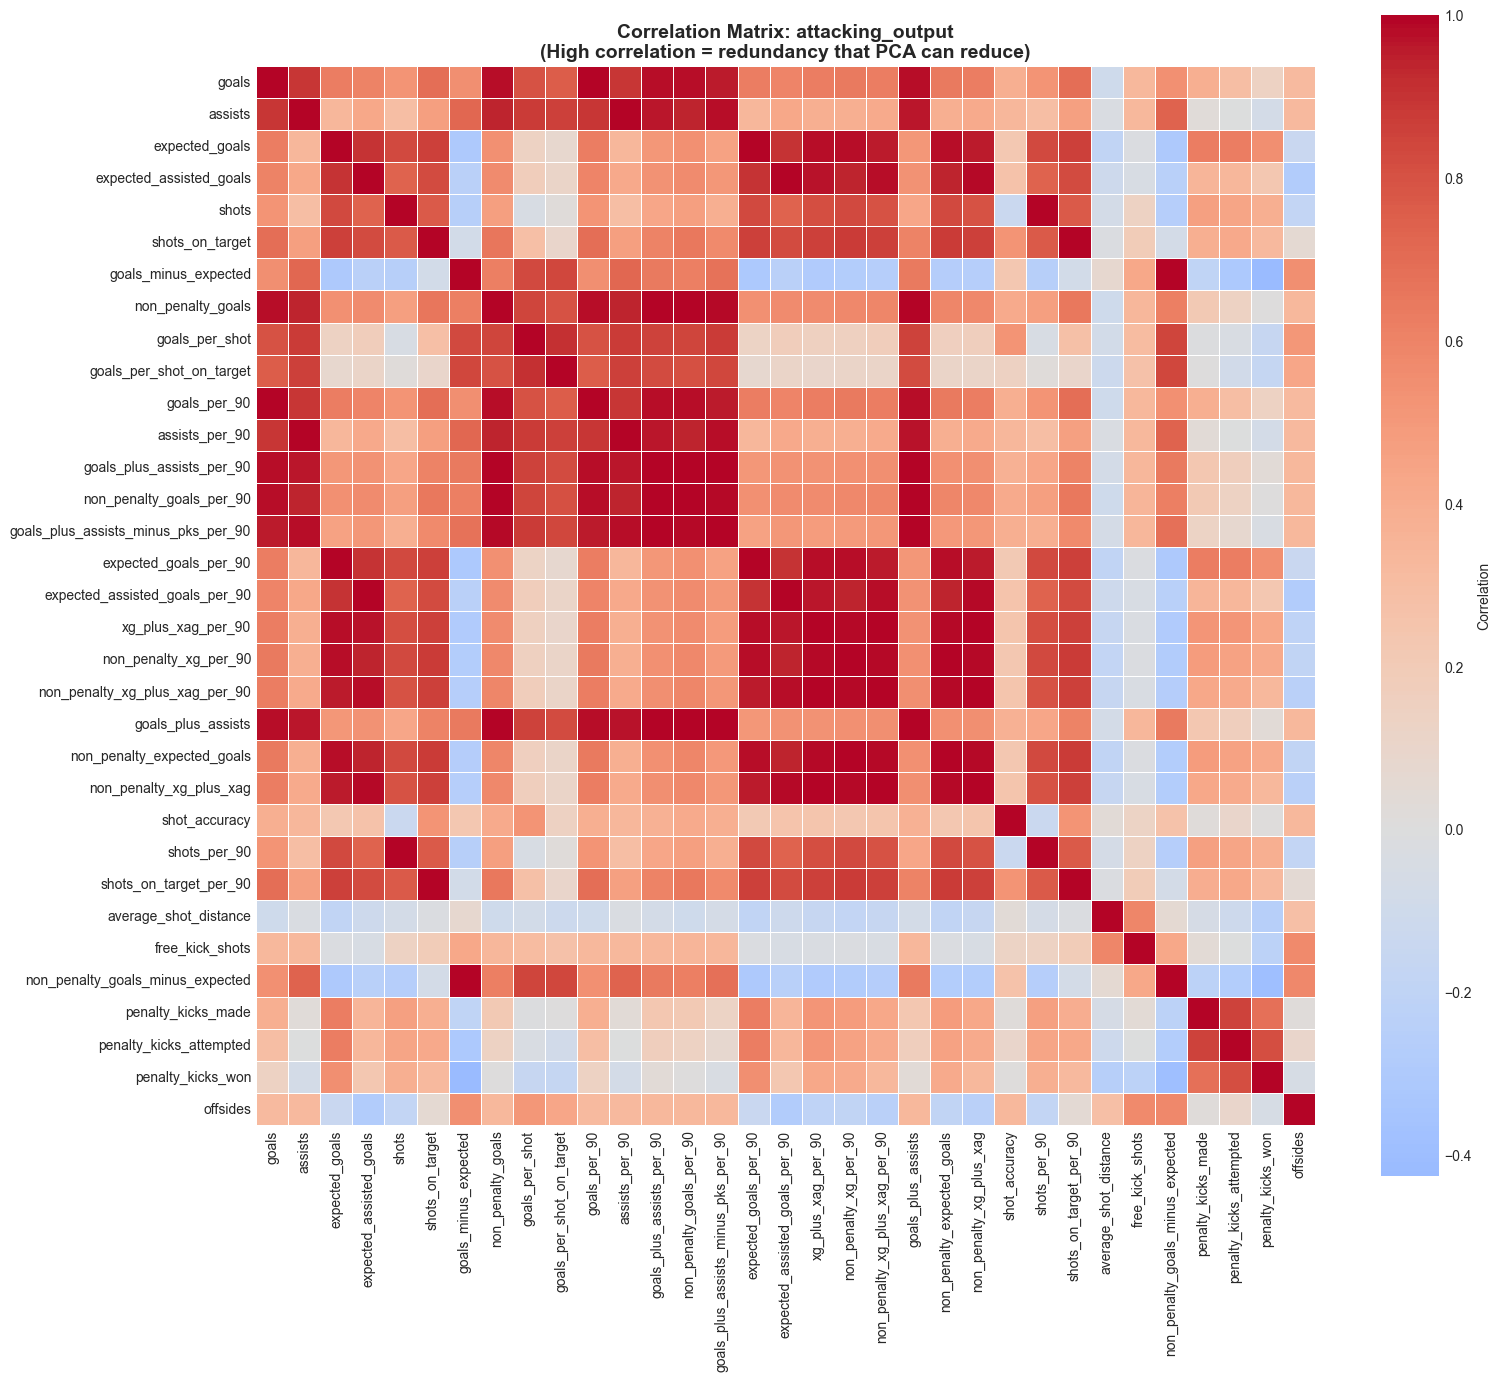


🔍 Highly correlated pairs (|r| > 0.8): 128

Top 10 correlations:
  shots <-> shots_per_90: 1.000
  goals_plus_assists_per_90 <-> goals_plus_assists: 1.000
  shots_on_target <-> shots_on_target_per_90: 1.000
  non_penalty_goals <-> non_penalty_goals_per_90: 1.000
  assists <-> assists_per_90: 1.000
  goals <-> goals_per_90: 1.000
  non_penalty_xg_plus_xag_per_90 <-> non_penalty_xg_plus_xag: 1.000
  non_penalty_xg_per_90 <-> non_penalty_expected_goals: 1.000
  expected_goals <-> expected_goals_per_90: 1.000
  expected_assisted_goals <-> expected_assisted_goals_per_90: 1.000


In [9]:
# Correlation matrix for example category
corr_matrix = example_df[example_metrics].corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5,
            cbar_kws={'label': 'Correlation'})
plt.title(f'Correlation Matrix: {example_category}\n(High correlation = redundancy that PCA can reduce)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))

print(f"\n🔍 Highly correlated pairs (|r| > 0.8): {len(high_corr_pairs)}")
if high_corr_pairs:
    print("\nTop 10 correlations:")
    sorted_pairs = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]
    for metric1, metric2, corr in sorted_pairs:
        print(f"  {metric1} <-> {metric2}: {corr:.3f}")

### 1.6 Critical Step: Invert Negative Metrics
**🚨 IMPORTANT: PCA Has No Domain Knowledge**

PCA only cares about **variance** (how much metrics differ). It doesn't know:
- Whether high goals is good ✅
- Whether high errors is bad ❌

#### The Problem

Consider two metrics:
- **Goals**: High = Good → Should contribute positively to composite score
- **Errors**: High = Bad → Should contribute negatively to composite score\n\nBut PCA treats both the same! If both vary a lot, PCA weights them equally based on variance alone.

#### The Solution: Invert Before PCA

We need to **flip negative metrics** so "lower is better" becomes "higher is better":
```python
# For negative metrics like errors or yellow_cards\nmetric_inverted = -metric  
# Now high inverted value = good (few errors)
```
 
After inversion:
- High goals → High value → Good ✅
- Low errors → High inverted value → Good ✅
**Both point in the same 'good' direction**

### Implementation

We use the `NEGATIVE_METRICS` set from `squad_analyzer.py` (line 182) which includes:
- Discipline: `yellow_cards`, `red_cards`, `fouls_committed`
- Errors: `errors`, `miscontrols`, `dispossessed`, `own_goals`
- Concessions: `goals_against`, `shots_on_target_against`
- And 20+ more metrics where lower = better

In [35]:
# Invert negative metrics in all category dataframes
print("🔄 Inverting negative metrics (where lower is better)...")
print(f"\nNegative metrics to invert: {len(NEGATIVE_METRICS)}")
print("Examples:", list(NEGATIVE_METRICS)[:10])

for category_name, category_dict in category_data.items():
    cat_df = category_dict['dataframe']
    metrics = category_dict['metrics']
    
    inverted_count = 0
    for metric in metrics:
        if metric in NEGATIVE_METRICS:
            # Invert: multiply by -1 so low values become high
            cat_df[metric] = -cat_df[metric]
            inverted_count += 1
    
    print(f"  {category_name:20s}: {inverted_count:2d} metrics inverted")

print("\n✅ All negative metrics inverted!")
print("\n💡 Now PCA will correctly treat 'low errors' as good performance.")

🔄 Inverting negative metrics (where lower is better)...

Negative metrics to invert: 27
Examples: ['own_goals', 'blocked_passes', 'free_kick_goals_against', 'take_ons_tackled_rate', 'second_yellow_cards', 'corner_kick_goals_against', 'fouls_committed', 'penalty_kicks_attempted_against', 'take_ons_tackled', 'aerial_duels_lost']
  attacking_output    :  2 metrics inverted
  creativity          :  0 metrics inverted
  passing             :  2 metrics inverted
  ball_progression    :  4 metrics inverted
  defending           : 13 metrics inverted
  physical_duels      :  5 metrics inverted
  possession          :  0 metrics inverted

✅ All negative metrics inverted!

💡 Now PCA will correctly treat 'low errors' as good performance.


#### Demonstration: Why Inversion Matters\n\nLet's see the impact of inversion with a concrete example from the defending category.

In [36]:
# Example: Compare errors and saves (defending category)
defending_df = category_data['defending']['dataframe']

# Pick two squads for comparison
example_squads = defending_df.head(2)

print("🔍 EXAMPLE: Defending Metrics Comparison")
print("="*60)

# Show a good metric (saves - higher is better)
if 'saves' in defending_df.columns:
    print(f"\n📊 SAVES (higher = better, NO inversion needed):")
    for _, row in example_squads.iterrows():
        print(f"   {row['squad_name']:20s}: {row['saves']:.1f} saves")

# Show a bad metric (errors - lower is better, WAS inverted)
if 'errors' in defending_df.columns:
    print(f"\n❌ ERRORS (lower = better, WAS INVERTED):")
    print(f"   Before inversion (raw data):")
    # We don't have original, but we can show the principle
    print(f"      Squad A: 2 errors  → After inversion: -2")
    print(f"      Squad B: 5 errors  → After inversion: -5")
    print(f"   ")
    print(f"   Now in PCA:")
    print(f"      Squad A: -2 (inverted) → Higher is better ✅")
    print(f"      Squad B: -5 (inverted) → Lower value = more errors ✅")

print(f"\n💡 Key Insight:")
print(f"   After inversion, ALL metrics point in the same direction:")
print(f"   Higher value = Better performance")
print(f"   ")
print(f"   This allows PCA to correctly weight metrics based on variance")
print(f"   without accidentally rewarding bad performance!")

🔍 EXAMPLE: Defending Metrics Comparison

📊 SAVES (higher = better, NO inversion needed):
   Arsenal             : 15.0 saves
   Aston Villa         : 15.0 saves

❌ ERRORS (lower = better, WAS INVERTED):
   Before inversion (raw data):
      Squad A: 2 errors  → After inversion: -2
      Squad B: 5 errors  → After inversion: -5
   
   Now in PCA:
      Squad A: -2 (inverted) → Higher is better ✅
      Squad B: -5 (inverted) → Lower value = more errors ✅

💡 Key Insight:
   After inversion, ALL metrics point in the same direction:
   Higher value = Better performance
   
   This allows PCA to correctly weight metrics based on variance
   without accidentally rewarding bad performance!


---
## Part 2: Per-Category PCA Implementation

### 2.1 PCA Theory Refresher

**What is PCA?**
- Finds directions (principal components) of maximum variance in the data
- PC1 captures most variance, PC2 captures second-most (orthogonal to PC1), etc.
- Each PC is a weighted combination of original features

**For Composite Scores:**
1. Standardize metrics (mean=0, std=1)
2. Fit PCA to find principal components
3. Use weighted combination of top PCs as composite score
4. Weights based on explained variance ratio

**Formula:**
```
composite_score = (PC1 * var_1 + PC2 * var_2 + ...) / sum(var_i)
```
where var_i is the explained variance ratio of PC_i

### 2.2 Detailed Example - Attacking Output Category

In [12]:
# Select category for detailed walkthrough
category = 'attacking_output'
cat_df = category_data[category]['dataframe']
metrics = category_data[category]['metrics']

print(f"🎯 Category: {category}")
print(f"📊 Metrics: {len(metrics)}")
print(f"🏟️  Squads: {len(cat_df)}")

# Step 1: Prepare data (just the metrics, not squad_name)
X = cat_df[metrics].values
squad_names = cat_df['squad_name'].values

print(f"\n📏 Data shape: {X.shape}")
print(f"   ({X.shape[0]} squads × {X.shape[1]} metrics)")

🎯 Category: attacking_output
📊 Metrics: 33
🏟️  Squads: 20

📏 Data shape: (20, 33)
   (20 squads × 33 metrics)


#### Step 2: Standardization

**Why standardize?**
- PCA is sensitive to scale
- Metrics with larger values would dominate
- Standardization: `(x - mean) / std` makes all metrics comparable

In [13]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Data standardized")
print(f"\nBefore standardization:")
print(f"  Mean: {X.mean(axis=0)[:3]} ...")
print(f"  Std:  {X.std(axis=0)[:3]} ...")

print(f"\nAfter standardization:")
print(f"  Mean: {X_scaled.mean(axis=0)[:3]} ... (≈ 0)")
print(f"  Std:  {X_scaled.std(axis=0)[:3]} ... (≈ 1)")

✅ Data standardized

Before standardization:
  Mean: [10.    7.05 10.36] ...
  Std:  [3.591657   2.97447474 3.16534358] ...

After standardization:
  Mean: [-1.11022302e-17  4.44089210e-17 -3.55271368e-16] ... (≈ 0)
  Std:  [1. 1. 1.] ... (≈ 1)


#### Step 3: Fit PCA

In [14]:
# Fit PCA with all components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"✅ PCA fitted")
print(f"\n📊 Principal Components: {pca.n_components_}")
print(f"📈 Explained Variance Ratio (top 10):")
for i, var in enumerate(pca.explained_variance_ratio_[:10]):
    print(f"   PC{i+1}: {var:.4f} ({var*100:.2f}%)")

# Cumulative explained variance
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
print(f"\n📊 Cumulative Variance Explained:")
for n in [1, 2, 3, 5, 10]:
    if n <= len(cumsum_var):
        print(f"   Top {n:2d} PCs: {cumsum_var[n-1]:.4f} ({cumsum_var[n-1]*100:.2f}%)")

✅ PCA fitted

📊 Principal Components: 20
📈 Explained Variance Ratio (top 10):
   PC1: 0.5237 (52.37%)
   PC2: 0.2626 (26.26%)
   PC3: 0.0633 (6.33%)
   PC4: 0.0540 (5.40%)
   PC5: 0.0419 (4.19%)
   PC6: 0.0180 (1.80%)
   PC7: 0.0115 (1.15%)
   PC8: 0.0107 (1.07%)
   PC9: 0.0066 (0.66%)
   PC10: 0.0042 (0.42%)

📊 Cumulative Variance Explained:
   Top  1 PCs: 0.5237 (52.37%)
   Top  2 PCs: 0.7863 (78.63%)
   Top  3 PCs: 0.8497 (84.97%)
   Top  5 PCs: 0.9456 (94.56%)
   Top 10 PCs: 0.9966 (99.66%)


#### Step 4: Scree Plot - How Many Components?

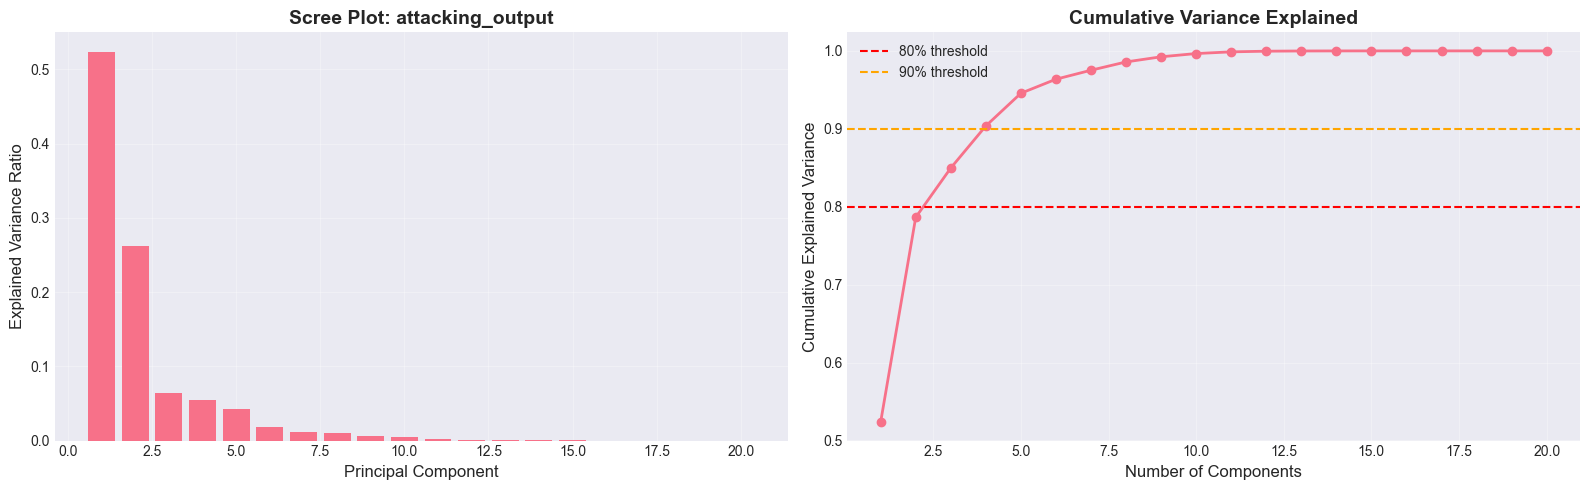


🎯 Components needed:
   80% variance: 3 components
   90% variance: 4 components


In [15]:
# Scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Explained variance per component
n_components_to_plot = min(20, len(pca.explained_variance_ratio_))
ax1.bar(range(1, n_components_to_plot + 1), 
        pca.explained_variance_ratio_[:n_components_to_plot])
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance Ratio', fontsize=12)
ax1.set_title(f'Scree Plot: {category}', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative explained variance
ax2.plot(range(1, n_components_to_plot + 1), 
         cumsum_var[:n_components_to_plot], 
         marker='o', linewidth=2)
ax2.axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
ax2.axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax2.set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for 80% and 90% variance
n_80 = np.argmax(cumsum_var >= 0.8) + 1
n_90 = np.argmax(cumsum_var >= 0.9) + 1
print(f"\n🎯 Components needed:")
print(f"   80% variance: {n_80} components")
print(f"   90% variance: {n_90} components")

#### Step 5: Feature Loadings - Which Metrics Matter Most?

**Loadings** show the contribution of each original metric to each PC.

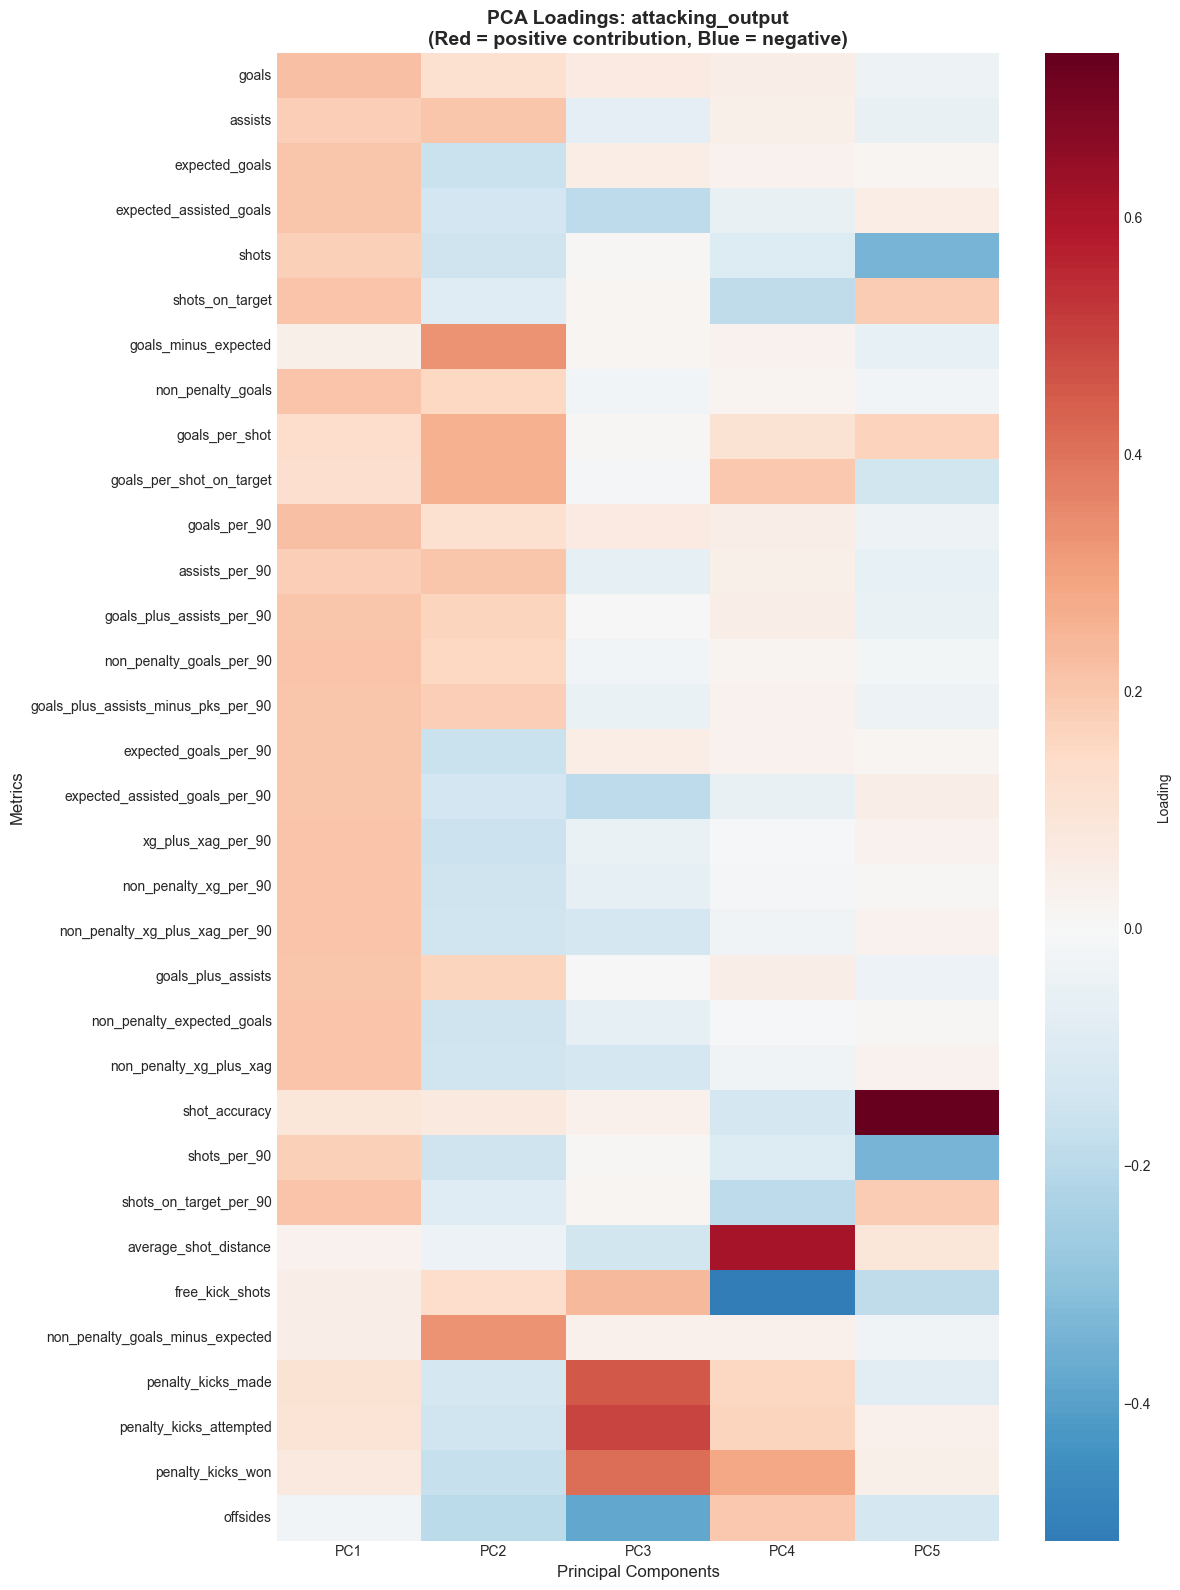


🏆 Top 10 contributors to PC1 (main driver of variance):
    1. goals                                    ↑ 0.2217
    2. goals_per_90                             ↑ 0.2216
    3. non_penalty_goals                        ↑ 0.2137
    4. non_penalty_goals_per_90                 ↑ 0.2137
    5. non_penalty_expected_goals               ↑ 0.2115
    6. non_penalty_xg_per_90                    ↑ 0.2112
    7. xg_plus_xag_per_90                       ↑ 0.2106
    8. non_penalty_xg_plus_xag_per_90           ↑ 0.2104
    9. non_penalty_xg_plus_xag                  ↑ 0.2101
   10. shots_on_target                          ↑ 0.2097


In [16]:
# Create loadings dataframe
n_top_pcs = min(5, pca.n_components_)  # Show top 5 PCs
loadings_df = pd.DataFrame(
    pca.components_[:n_top_pcs].T,
    columns=[f'PC{i+1}' for i in range(n_top_pcs)],
    index=metrics
)

# Plot loadings heatmap
plt.figure(figsize=(12, 16))
sns.heatmap(loadings_df, cmap='RdBu_r', center=0, 
            annot=False, fmt='.2f',
            cbar_kws={'label': 'Loading'})
plt.title(f'PCA Loadings: {category}\n(Red = positive contribution, Blue = negative)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Principal Components', fontsize=12)
plt.ylabel('Metrics', fontsize=12)
plt.tight_layout()
plt.show()

# Show top contributors to PC1
print(f"\n🏆 Top 10 contributors to PC1 (main driver of variance):")
pc1_loadings = loadings_df['PC1'].abs().sort_values(ascending=False)
for i, (metric, loading) in enumerate(pc1_loadings.head(10).items()):
    actual_loading = loadings_df.loc[metric, 'PC1']
    direction = '↑' if actual_loading > 0 else '↓'
    print(f"   {i+1:2d}. {metric:40s} {direction} {abs(actual_loading):.4f}")

#### Step 6: Create Weighted Composite Score

We'll use a weighted combination of top PCs, weighted by their explained variance.

In [17]:
# Decide how many components to use (let's use components explaining 80% variance)
n_components_to_use = n_80

print(f"🎯 Using top {n_components_to_use} components (explaining {cumsum_var[n_components_to_use-1]*100:.2f}% variance)")

# Get weights (explained variance ratios)
weights = pca.explained_variance_ratio_[:n_components_to_use]
weights_normalized = weights / weights.sum()  # Normalize to sum to 1

print(f"\n📊 Component weights:")
for i, w in enumerate(weights_normalized):
    print(f"   PC{i+1}: {w:.4f} ({w*100:.2f}%)")

# Calculate weighted composite score
# Formula: composite = sum(PC_i * weight_i)
pca_scores_raw = np.dot(X_pca[:, :n_components_to_use], weights_normalized)

# Normalize to 0-100 scale for interpretability
pca_scores_normalized = ((pca_scores_raw - pca_scores_raw.min()) / 
                         (pca_scores_raw.max() - pca_scores_raw.min())) * 100

print(f"\n✅ PCA composite scores calculated")
print(f"   Range: {pca_scores_normalized.min():.2f} to {pca_scores_normalized.max():.2f}")
print(f"   Mean: {pca_scores_normalized.mean():.2f}")
print(f"   Std: {pca_scores_normalized.std():.2f}")

🎯 Using top 3 components (explaining 84.97% variance)

📊 Component weights:
   PC1: 0.6163 (61.63%)
   PC2: 0.3091 (30.91%)
   PC3: 0.0745 (7.45%)

✅ PCA composite scores calculated
   Range: 0.00 to 100.00
   Mean: 48.30
   Std: 30.96


#### Step 7: Compare with Equal-Weight Composite Score

In [18]:
# Calculate equal-weight composite score using existing method
equal_weight_results = analyzer.calculate_category_composite_scores(category, timeframe)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'squad_name': squad_names,
    'pca_score': pca_scores_normalized
})

# Merge with equal-weight scores
comparison_df = comparison_df.merge(
    equal_weight_results[['squad_name', 'composite_score', 'rank']],
    on='squad_name',
    suffixes=('_pca', '_equal')
)
comparison_df.rename(columns={'composite_score': 'equal_weight_score', 'rank': 'equal_weight_rank'}, inplace=True)

# Add PCA rank
comparison_df = comparison_df.sort_values('pca_score', ascending=False).reset_index(drop=True)
comparison_df['pca_rank'] = range(1, len(comparison_df) + 1)

# Calculate rank difference
comparison_df['rank_difference'] = comparison_df['equal_weight_rank'] - comparison_df['pca_rank']
comparison_df['score_difference'] = comparison_df['pca_score'] - comparison_df['equal_weight_score']

# Display comparison
print(f"\n📊 {category.upper()} - PCA vs Equal-Weight Comparison\n")
print(comparison_df[['squad_name', 'pca_rank', 'pca_score', 'equal_weight_rank', 
                     'equal_weight_score', 'rank_difference']].to_string(index=False))

# Summary statistics
print(f"\n📈 Summary:")
print(f"   Correlation between scores: {comparison_df['pca_score'].corr(comparison_df['equal_weight_score']):.4f}")
print(f"   Mean absolute rank difference: {comparison_df['rank_difference'].abs().mean():.2f} positions")
print(f"   Max rank change: {comparison_df['rank_difference'].abs().max():.0f} positions")


📊 ATTACKING_OUTPUT - PCA vs Equal-Weight Comparison

     squad_name  pca_rank  pca_score  equal_weight_rank  equal_weight_score  rank_difference
Manchester City         1     100.00                  1               79.15                0
        Chelsea         2      98.35                  2               71.03                0
      Liverpool         3      84.52                  3               69.97                0
    Bournemouth         4      82.94                  6               60.55                2
        Arsenal         5      82.68                  4               69.45               -1
      Tottenham         6      74.41                  9               51.30                3
       Brighton         7      66.17                  8               54.74                1
 Crystal Palace         8      64.16                  5               65.44               -3
      Brentford         9      53.02                 10               49.94                1
 Manchester Utd 

#### Step 8: Visualize Comparison

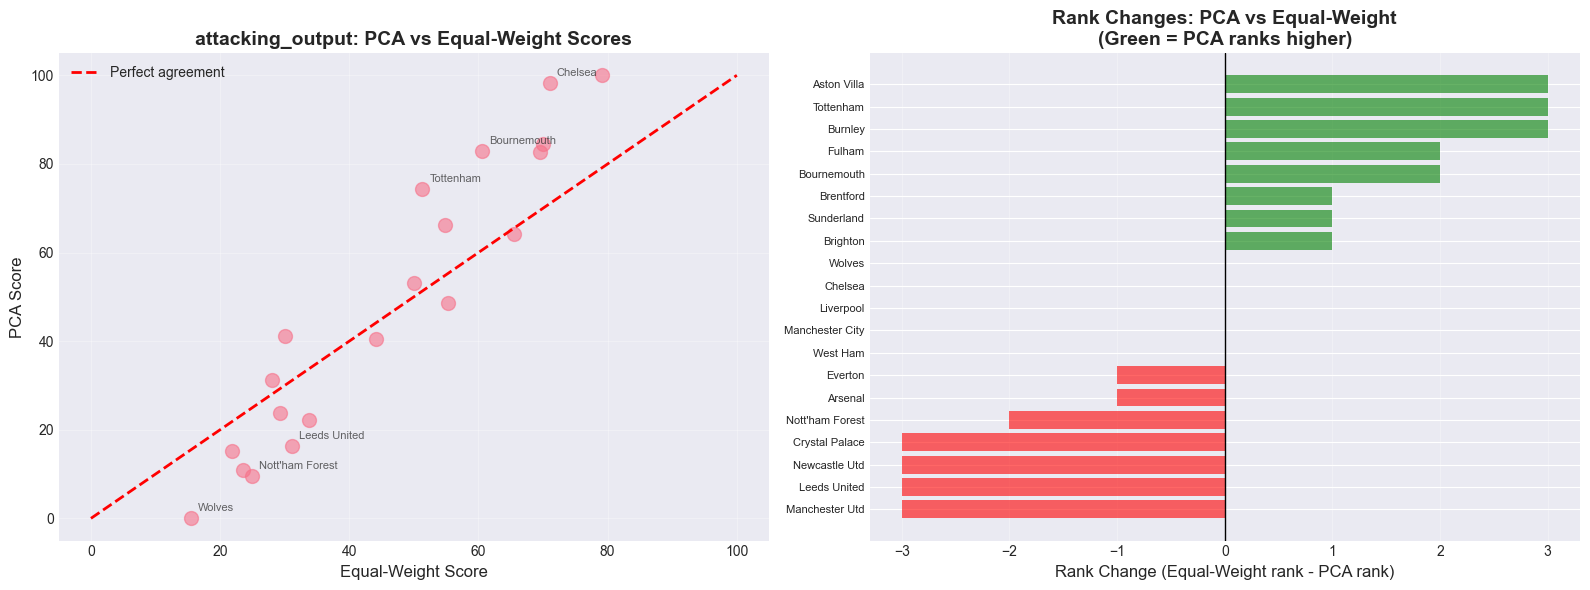

In [19]:
# Scatter plot: PCA vs Equal-Weight scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Score correlation
ax1.scatter(comparison_df['equal_weight_score'], comparison_df['pca_score'], alpha=0.6, s=100)
ax1.plot([0, 100], [0, 100], 'r--', label='Perfect agreement', linewidth=2)

# Annotate biggest movers
top_movers = comparison_df.nlargest(3, 'score_difference')
bottom_movers = comparison_df.nsmallest(3, 'score_difference')
for _, row in pd.concat([top_movers, bottom_movers]).iterrows():
    ax1.annotate(row['squad_name'], 
                xy=(row['equal_weight_score'], row['pca_score']),
                xytext=(5, 5), textcoords='offset points', 
                fontsize=8, alpha=0.7)

ax1.set_xlabel('Equal-Weight Score', fontsize=12)
ax1.set_ylabel('PCA Score', fontsize=12)
ax1.set_title(f'{category}: PCA vs Equal-Weight Scores', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Rank differences
comparison_df_sorted = comparison_df.sort_values('rank_difference')
colors = ['green' if x > 0 else 'red' for x in comparison_df_sorted['rank_difference']]
ax2.barh(range(len(comparison_df_sorted)), comparison_df_sorted['rank_difference'], color=colors, alpha=0.6)
ax2.set_yticks(range(len(comparison_df_sorted)))
ax2.set_yticklabels(comparison_df_sorted['squad_name'], fontsize=8)
ax2.set_xlabel('Rank Change (Equal-Weight rank - PCA rank)', fontsize=12)
ax2.set_title('Rank Changes: PCA vs Equal-Weight\n(Green = PCA ranks higher)', 
             fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

#### Step 9: Save PCA Model for Future Use

In [20]:
# Create directory for models
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)

# Save PCA model and scaler
model_data = {
    'pca': pca,
    'scaler': scaler,
    'metrics': metrics,
    'n_components_used': n_components_to_use,
    'weights': weights_normalized,
    'category': category,
    'explained_variance': cumsum_var[n_components_to_use-1]
}

model_path = models_dir / f'pca_{category}.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model_data, f)

print(f"✅ PCA model saved: {model_path}")
print(f"\n📦 Model contents:")
print(f"   - PCA transformer ({n_components_to_use} components)")
print(f"   - StandardScaler")
print(f"   - Metric names ({len(metrics)})")
print(f"   - Component weights")
print(f"   - Explained variance: {cumsum_var[n_components_to_use-1]*100:.2f}%")

✅ PCA model saved: models/pca_attacking_output.pkl

📦 Model contents:
   - PCA transformer (3 components)
   - StandardScaler
   - Metric names (33)
   - Component weights
   - Explained variance: 84.97%


---
### 2.3 Apply PCA to ALL Categories

Now let's automate this process for all 7 categories.

In [21]:
def apply_pca_to_category(category_name, category_dict, analyzer, timeframe='current', 
                          variance_threshold=0.80, verbose=False):
    """
    Apply PCA to a category and return comprehensive results.
    
    Args:
        category_name: Name of the category
        category_dict: Dictionary with 'dataframe', 'metrics', 'description'
        analyzer: SquadAnalyzer instance
        timeframe: Timeframe for equal-weight comparison
        variance_threshold: Cumulative variance threshold for component selection
        verbose: Print detailed information
    
    Returns:
        Dictionary with PCA results and comparisons
    """
    cat_df = category_dict['dataframe']
    metrics = category_dict['metrics']
    
    if verbose:
        print(f"\n{'='*80}")
        print(f"🎯 Processing: {category_name}")
        print(f"{'='*80}")
    
    # Prepare data
    X = cat_df[metrics].values
    squad_names = cat_df['squad_name'].values
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Determine number of components
    cumsum_var = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumsum_var >= variance_threshold) + 1
    
    # Calculate weights
    weights = pca.explained_variance_ratio_[:n_components]
    weights_normalized = weights / weights.sum()
    
    # Calculate PCA composite score
    pca_scores_raw = np.dot(X_pca[:, :n_components], weights_normalized)
    pca_scores = ((pca_scores_raw - pca_scores_raw.min()) / 
                  (pca_scores_raw.max() - pca_scores_raw.min())) * 100
    
    # Get equal-weight scores for comparison
    equal_weight_results = analyzer.calculate_category_composite_scores(category_name, timeframe)
    
    # Create comparison
    comparison_df = pd.DataFrame({
        'squad_name': squad_names,
        'pca_score': pca_scores
    })
    comparison_df = comparison_df.merge(
        equal_weight_results[['squad_name', 'composite_score', 'rank']],
        on='squad_name'
    )
    comparison_df.rename(columns={'composite_score': 'equal_weight_score', 'rank': 'equal_weight_rank'}, 
                        inplace=True)
    
    comparison_df = comparison_df.sort_values('pca_score', ascending=False).reset_index(drop=True)
    comparison_df['pca_rank'] = range(1, len(comparison_df) + 1)
    comparison_df['rank_difference'] = comparison_df['equal_weight_rank'] - comparison_df['pca_rank']
    comparison_df['score_difference'] = comparison_df['pca_score'] - comparison_df['equal_weight_score']
    
    # Feature loadings
    loadings_df = pd.DataFrame(
        pca.components_[:n_components].T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=metrics
    )
    
    # Top contributors to PC1
    pc1_contributors = loadings_df['PC1'].abs().sort_values(ascending=False).head(10)
    
    if verbose:
        print(f"\n📊 Results:")
        print(f"   Components used: {n_components} (explaining {cumsum_var[n_components-1]*100:.2f}% variance)")
        print(f"   Score correlation: {comparison_df['pca_score'].corr(comparison_df['equal_weight_score']):.4f}")
        print(f"   Mean rank difference: {comparison_df['rank_difference'].abs().mean():.2f}")
        print(f"\n   Top 3 squads (PCA):")
        for i, row in comparison_df.head(3).iterrows():
            print(f"      {row['pca_rank']}. {row['squad_name']:25s} {row['pca_score']:.2f}")
    
    # Save model
    models_dir = Path('models')
    models_dir.mkdir(exist_ok=True)
    
    model_data = {
        'pca': pca,
        'scaler': scaler,
        'metrics': metrics,
        'n_components_used': n_components,
        'weights': weights_normalized,
        'category': category_name,
        'explained_variance': cumsum_var[n_components-1],
        'variance_threshold': variance_threshold
    }
    
    model_path = models_dir / f'pca_{category_name}.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(model_data, f)
    
    return {
        'category': category_name,
        'pca': pca,
        'scaler': scaler,
        'n_components': n_components,
        'weights': weights_normalized,
        'explained_variance': cumsum_var[n_components-1],
        'comparison_df': comparison_df,
        'loadings_df': loadings_df,
        'pc1_contributors': pc1_contributors,
        'model_path': model_path
    }

print("✅ Function defined: apply_pca_to_category()")

✅ Function defined: apply_pca_to_category()


In [22]:
# Apply PCA to all categories
pca_results = {}

print("🚀 Applying PCA to all categories...\n")
print("="*80)

for category_name in category_data.keys():
    results = apply_pca_to_category(
        category_name, 
        category_data[category_name],
        analyzer,
        timeframe='current',
        variance_threshold=0.80,
        verbose=True
    )
    pca_results[category_name] = results

print("\n" + "="*80)
print("✅ PCA applied to all categories!")
print(f"\n📦 Models saved in: ./models/")

🚀 Applying PCA to all categories...


🎯 Processing: attacking_output

📊 Results:
   Components used: 3 (explaining 84.97% variance)
   Score correlation: 0.9559
   Mean rank difference: 1.60

   Top 3 squads (PCA):
      1. Manchester City           100.00
      2. Chelsea                   98.35
      3. Liverpool                 84.52

🎯 Processing: creativity

📊 Results:
   Components used: 6 (explaining 84.10% variance)
   Score correlation: 0.9512
   Mean rank difference: 1.20

   Top 3 squads (PCA):
      1. Liverpool                 100.00
      2. Arsenal                   95.94
      3. Manchester Utd            76.09

🎯 Processing: passing

📊 Results:
   Components used: 4 (explaining 80.76% variance)
   Score correlation: 0.9320
   Mean rank difference: 2.10

   Top 3 squads (PCA):
      1. Liverpool                 100.00
      2. Manchester City           99.38
      3. Chelsea                   87.37

🎯 Processing: ball_progression

📊 Results:
   Components used: 4 (expla

---
## Part 3: Deep-Dive PCA Insights

### 3.1 Summary Statistics Across All Categories

In [23]:
# Create summary table
summary_data = []

for cat_name, results in pca_results.items():
    comp_df = results['comparison_df']
    correlation = comp_df['pca_score'].corr(comp_df['equal_weight_score'])
    mean_rank_diff = comp_df['rank_difference'].abs().mean()
    max_rank_diff = comp_df['rank_difference'].abs().max()
    
    summary_data.append({
        'Category': cat_name,
        'Components Used': results['n_components'],
        'Variance Explained': f"{results['explained_variance']*100:.1f}%",
        'Score Correlation': f"{correlation:.4f}",
        'Mean Rank Diff': f"{mean_rank_diff:.2f}",
        'Max Rank Diff': int(max_rank_diff)
    })

summary_df = pd.DataFrame(summary_data)

print("\n📊 PCA SUMMARY ACROSS ALL CATEGORIES")
print("="*80)
print(summary_df.to_string(index=False))
print("\nInterpretation:")
print("  - High correlation = PCA agrees with equal-weight")
print("  - Low correlation = PCA captures different structure")
print("  - Rank differences show reordering magnitude")


📊 PCA SUMMARY ACROSS ALL CATEGORIES
        Category  Components Used Variance Explained Score Correlation Mean Rank Diff  Max Rank Diff
attacking_output                3              85.0%            0.9559           1.60              3
      creativity                6              84.1%            0.9512           1.20              5
         passing                4              80.8%            0.9320           2.10              8
ball_progression                4              81.4%            0.9075           2.00              6
       defending                7              84.4%            0.7039           4.00              9
  physical_duels                5              82.6%            0.9351           1.80              7
      possession                3              82.6%            0.6637           3.20             11

Interpretation:
  - High correlation = PCA agrees with equal-weight
  - Low correlation = PCA captures different structure
  - Rank differences show reord

### 3.2 Feature Importance - PC1 Loadings Across Categories

See which metrics dominate the first principal component in each category.

In [24]:
# For each category, get top 10 PC1 loadings
for cat_name, results in pca_results.items():
    print(f"\n{'='*80}")
    print(f"📊 {cat_name.upper()} - Top 10 PC1 Contributors")
    print(f"{'='*80}")
    print(f"\n(PC1 explains {results['pca'].explained_variance_ratio_[0]*100:.2f}% of variance)\n")
    
    loadings = results['loadings_df']['PC1'].abs().sort_values(ascending=False).head(10)
    
    for i, (metric, loading) in enumerate(loadings.items()):
        actual_loading = results['loadings_df'].loc[metric, 'PC1']
        direction = '↑' if actual_loading > 0 else '↓'
        bar = '█' * int(loading * 50)
        print(f"{i+1:2d}. {metric:45s} {direction} {abs(actual_loading):.4f} {bar}")


📊 ATTACKING_OUTPUT - Top 10 PC1 Contributors

(PC1 explains 52.37% of variance)

 1. goals                                         ↑ 0.2217 ███████████
 2. goals_per_90                                  ↑ 0.2216 ███████████
 3. non_penalty_goals                             ↑ 0.2137 ██████████
 4. non_penalty_goals_per_90                      ↑ 0.2137 ██████████
 5. non_penalty_expected_goals                    ↑ 0.2115 ██████████
 6. non_penalty_xg_per_90                         ↑ 0.2112 ██████████
 7. xg_plus_xag_per_90                            ↑ 0.2106 ██████████
 8. non_penalty_xg_plus_xag_per_90                ↑ 0.2104 ██████████
 9. non_penalty_xg_plus_xag                       ↑ 0.2101 ██████████
10. shots_on_target                               ↑ 0.2097 ██████████

📊 CREATIVITY - Top 10 PC1 Contributors

(PC1 explains 35.49% of variance)

 1. sca_pass_live                                 ↑ 0.2940 ██████████████
 2. shot_creating_actions_per_90                  ↑ 0.2847 ███████

### 3.3 Explained Variance Comparison Across Categories

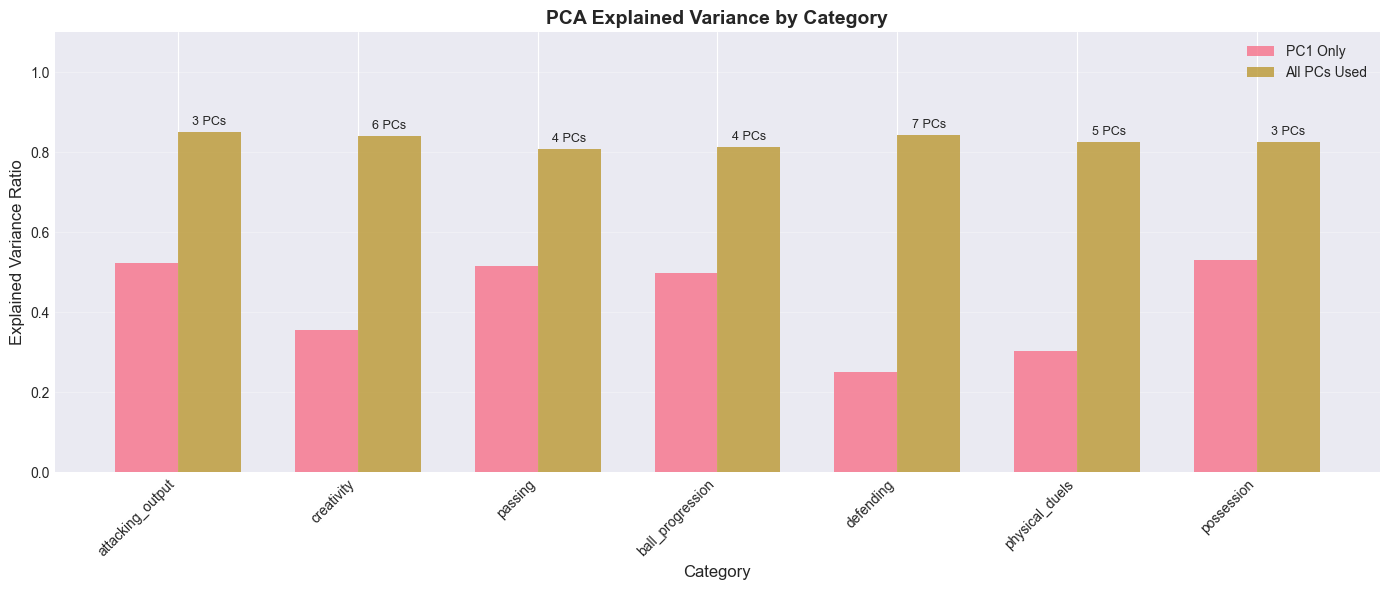


💡 Insight:
   Categories where PC1 is very high = metrics are highly correlated (redundant)
   Categories needing many PCs = metrics capture diverse aspects


In [25]:
# Compare PC1 explained variance across categories
fig, ax = plt.subplots(figsize=(14, 6))

categories = list(pca_results.keys())
pc1_variances = [pca_results[cat]['pca'].explained_variance_ratio_[0] for cat in categories]
total_variances = [pca_results[cat]['explained_variance'] for cat in categories]
n_components = [pca_results[cat]['n_components'] for cat in categories]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, pc1_variances, width, label='PC1 Only', alpha=0.8)
bars2 = ax.bar(x + width/2, total_variances, width, label='All PCs Used', alpha=0.8)

# Add component count labels
for i, (bar, n) in enumerate(zip(bars2, n_components)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{n} PCs', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Explained Variance Ratio', fontsize=12)
ax.set_title('PCA Explained Variance by Category', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("\n💡 Insight:")
print("   Categories where PC1 is very high = metrics are highly correlated (redundant)")
print("   Categories needing many PCs = metrics capture diverse aspects")

---
## Part 4: Comparison & Validation

### 4.1 Biggest Ranking Changes by Category

In [26]:
# For each category, find squads with biggest ranking changes
for cat_name, results in pca_results.items():
    comp_df = results['comparison_df']
    
    print(f"\n{'='*80}")
    print(f"🔄 {cat_name.upper()} - Biggest Ranking Changes")
    print(f"{'='*80}\n")
    
    # Top 5 gainers (PCA ranks higher)
    gainers = comp_df.nlargest(5, 'rank_difference')
    print("📈 PCA ranks HIGHER (vs equal-weight):")
    print(gainers[['squad_name', 'pca_rank', 'equal_weight_rank', 'rank_difference']].to_string(index=False))
    
    # Top 5 losers (PCA ranks lower)
    losers = comp_df.nsmallest(5, 'rank_difference')
    print("\n📉 PCA ranks LOWER (vs equal-weight):")
    print(losers[['squad_name', 'pca_rank', 'equal_weight_rank', 'rank_difference']].to_string(index=False))


🔄 ATTACKING_OUTPUT - Biggest Ranking Changes

📈 PCA ranks HIGHER (vs equal-weight):
 squad_name  pca_rank  equal_weight_rank  rank_difference
  Tottenham         6                  9                3
    Burnley        11                 14                3
Aston Villa        13                 16                3
Bournemouth         4                  6                2
     Fulham        17                 19                2

📉 PCA ranks LOWER (vs equal-weight):
     squad_name  pca_rank  equal_weight_rank  rank_difference
 Crystal Palace         8                  5               -3
 Manchester Utd        10                  7               -3
  Newcastle Utd        15                 12               -3
   Leeds United        16                 13               -3
Nott'ham Forest        19                 17               -2

🔄 CREATIVITY - Biggest Ranking Changes

📈 PCA ranks HIGHER (vs equal-weight):
     squad_name  pca_rank  equal_weight_rank  rank_difference
Nott'ham Forest 

### 4.2 Squad-Level Analysis - Individual Squad Across Categories

Pick a squad and see how PCA affects their ranking in each category.


🔍 ARSENAL - Category Performance (PCA vs Equal-Weight)

        Category  PCA Rank  Equal-Weight Rank  Rank Change PCA Score Equal-Weight Score
attacking_output         5                  4           -1     82.68              69.45
      creativity         2                  1           -1     95.94              68.43
         passing         5                  4           -1     77.77              61.69
ball_progression         2                  1           -1     82.57              73.03
       defending         2                 11            9     96.40              48.66
  physical_duels         3                  4            1     69.00              58.29
      possession         6                  6            0     74.39              51.91


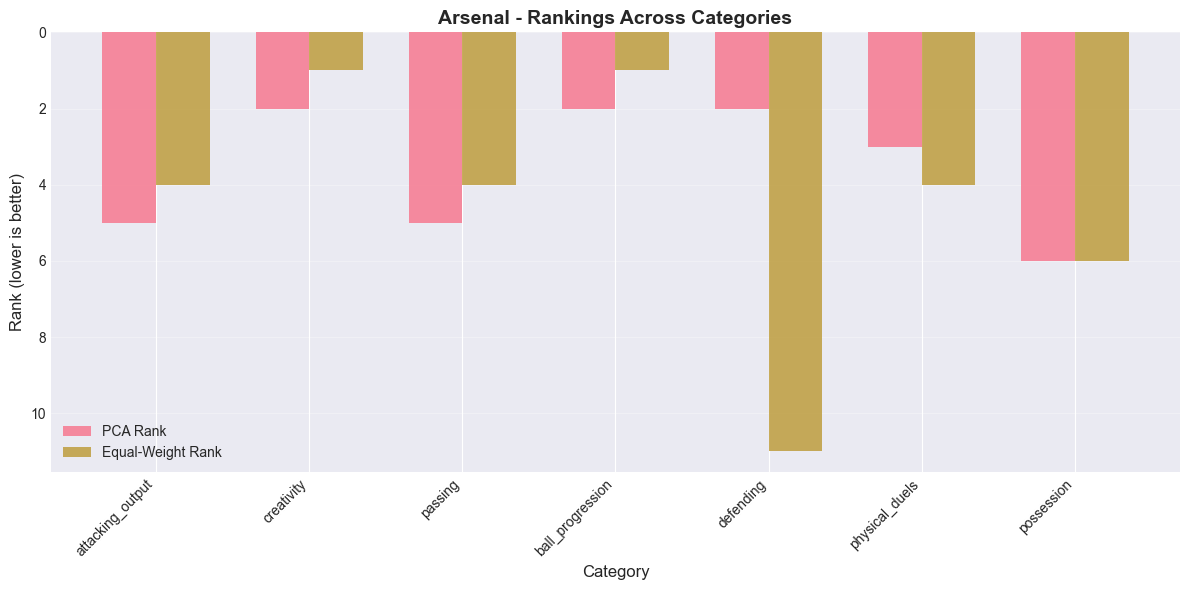

In [27]:
# Choose a squad to analyze
example_squad = 'Arsenal'  # Change this to any squad

squad_comparison = []

for cat_name, results in pca_results.items():
    comp_df = results['comparison_df']
    squad_row = comp_df[comp_df['squad_name'] == example_squad]
    
    if not squad_row.empty:
        squad_comparison.append({
            'Category': cat_name,
            'PCA Rank': int(squad_row['pca_rank'].values[0]),
            'Equal-Weight Rank': int(squad_row['equal_weight_rank'].values[0]),
            'Rank Change': int(squad_row['rank_difference'].values[0]),
            'PCA Score': f"{squad_row['pca_score'].values[0]:.2f}",
            'Equal-Weight Score': f"{squad_row['equal_weight_score'].values[0]:.2f}"
        })

squad_comp_df = pd.DataFrame(squad_comparison)

print(f"\n{'='*80}")
print(f"🔍 {example_squad.upper()} - Category Performance (PCA vs Equal-Weight)")
print(f"{'='*80}\n")
print(squad_comp_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

categories = squad_comp_df['Category'].values
pca_ranks = squad_comp_df['PCA Rank'].values
equal_ranks = squad_comp_df['Equal-Weight Rank'].values

x = np.arange(len(categories))
width = 0.35

ax.bar(x - width/2, pca_ranks, width, label='PCA Rank', alpha=0.8)
ax.bar(x + width/2, equal_ranks, width, label='Equal-Weight Rank', alpha=0.8)

ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Rank (lower is better)', fontsize=12)
ax.set_title(f'{example_squad} - Rankings Across Categories', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()
ax.invert_yaxis()  # Invert so rank 1 is at top
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 4.3 Overall Correlation Analysis

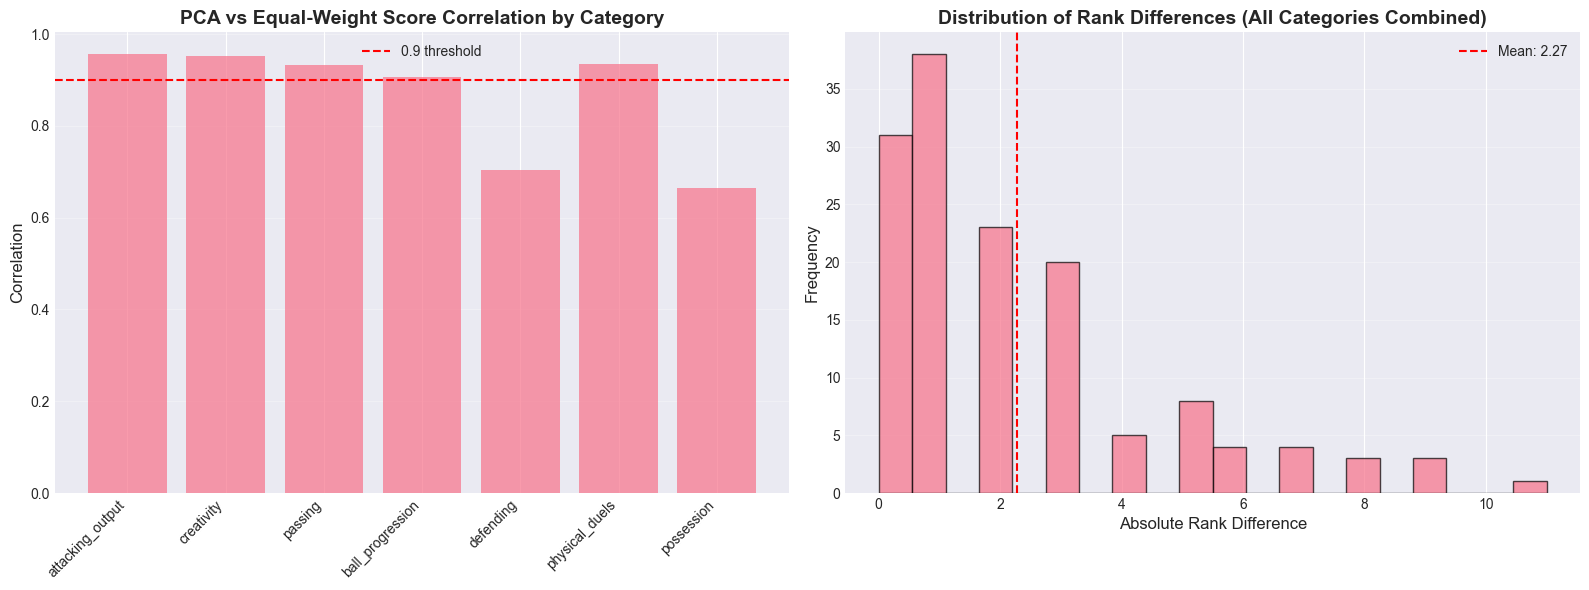


📊 Overall Statistics:
   Mean correlation across categories: 0.8642
   Mean absolute rank difference: 2.27
   Max rank difference observed: 11


In [28]:
# Distribution of score correlations
correlations = [pca_results[cat]['comparison_df']['pca_score'].corr(
    pca_results[cat]['comparison_df']['equal_weight_score']) for cat in pca_results.keys()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bar chart of correlations
ax1.bar(range(len(correlations)), correlations, alpha=0.7)
ax1.set_xticks(range(len(correlations)))
ax1.set_xticklabels(list(pca_results.keys()), rotation=45, ha='right')
ax1.set_ylabel('Correlation', fontsize=12)
ax1.set_title('PCA vs Equal-Weight Score Correlation by Category', fontsize=14, fontweight='bold')
ax1.axhline(y=0.9, color='r', linestyle='--', label='0.9 threshold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Distribution of rank differences across all categories
all_rank_diffs = []
for cat_name, results in pca_results.items():
    all_rank_diffs.extend(results['comparison_df']['rank_difference'].abs().values)

ax2.hist(all_rank_diffs, bins=20, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Absolute Rank Difference', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Rank Differences (All Categories Combined)', 
             fontsize=14, fontweight='bold')
ax2.axvline(x=np.mean(all_rank_diffs), color='r', linestyle='--', 
           label=f'Mean: {np.mean(all_rank_diffs):.2f}')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n📊 Overall Statistics:")
print(f"   Mean correlation across categories: {np.mean(correlations):.4f}")
print(f"   Mean absolute rank difference: {np.mean(all_rank_diffs):.2f}")
print(f"   Max rank difference observed: {int(np.max(all_rank_diffs))}")

---
## Part 5: Global PCA Exploration

### 5.1 Apply PCA Across ALL Metrics from ALL Categories

This creates a single overall squad quality composite score.

In [29]:
# Collect all metrics from all categories
all_metrics = []
for cat_name, cat_dict in category_data.items():
    all_metrics.extend(cat_dict['metrics'])

# Remove duplicates (some metrics might appear in multiple categories)
all_metrics = list(set(all_metrics))
all_metrics = [m for m in all_metrics if m in df_all_squads.columns]

print(f"🌐 GLOBAL PCA - Across All Categories")
print(f"{'='*80}")
print(f"\nTotal unique metrics: {len(all_metrics)}")
print(f"Squads: {len(df_all_squads)}")

# Prepare data
global_df = df_all_squads[['squad_name'] + all_metrics].copy()

# Handle missing values
for metric in all_metrics:
    if global_df[metric].isna().any():
        global_df[metric].fillna(global_df[metric].median(), inplace=True)

X_global = global_df[all_metrics].values
squad_names_global = global_df['squad_name'].values

# Standardize
scaler_global = StandardScaler()
X_global_scaled = scaler_global.fit_transform(X_global)

# Fit PCA
pca_global = PCA()
X_global_pca = pca_global.fit_transform(X_global_scaled)

print(f"\n✅ Global PCA fitted")
print(f"\n📊 Top 10 Principal Components:")
for i, var in enumerate(pca_global.explained_variance_ratio_[:10]):
    print(f"   PC{i+1}: {var:.4f} ({var*100:.2f}%)")

cumsum_var_global = np.cumsum(pca_global.explained_variance_ratio_)
n_80_global = np.argmax(cumsum_var_global >= 0.80) + 1
n_90_global = np.argmax(cumsum_var_global >= 0.90) + 1

print(f"\n🎯 Components needed:")
print(f"   80% variance: {n_80_global} components")
print(f"   90% variance: {n_90_global} components")

🌐 GLOBAL PCA - Across All Categories

Total unique metrics: 169
Squads: 20

✅ Global PCA fitted

📊 Top 10 Principal Components:
   PC1: 0.3075 (30.75%)
   PC2: 0.1155 (11.55%)
   PC3: 0.0989 (9.89%)
   PC4: 0.0728 (7.28%)
   PC5: 0.0617 (6.17%)
   PC6: 0.0451 (4.51%)
   PC7: 0.0407 (4.07%)
   PC8: 0.0376 (3.76%)
   PC9: 0.0334 (3.34%)
   PC10: 0.0288 (2.88%)

🎯 Components needed:
   80% variance: 9 components
   90% variance: 13 components


### 5.2 Global Scree Plot

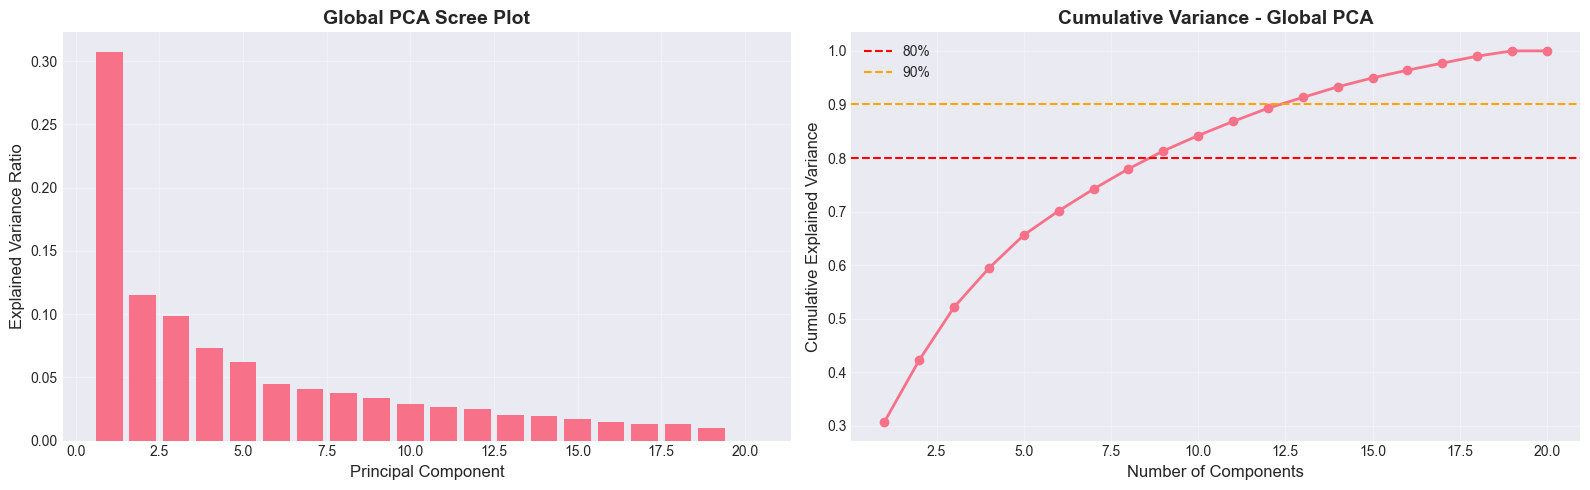

In [30]:
# Scree plot for global PCA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

n_plot = min(30, len(pca_global.explained_variance_ratio_))

# Explained variance
ax1.bar(range(1, n_plot + 1), pca_global.explained_variance_ratio_[:n_plot])
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance Ratio', fontsize=12)
ax1.set_title('Global PCA Scree Plot', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Cumulative variance
ax2.plot(range(1, n_plot + 1), cumsum_var_global[:n_plot], marker='o', linewidth=2)
ax2.axhline(y=0.8, color='r', linestyle='--', label='80%')
ax2.axhline(y=0.9, color='orange', linestyle='--', label='90%')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax2.set_title('Cumulative Variance - Global PCA', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Create Global Composite Score

In [31]:
# Use components explaining 80% variance
n_components_global = n_80_global

weights_global = pca_global.explained_variance_ratio_[:n_components_global]
weights_global_normalized = weights_global / weights_global.sum()

# Calculate global composite score
global_scores_raw = np.dot(X_global_pca[:, :n_components_global], weights_global_normalized)
global_scores = ((global_scores_raw - global_scores_raw.min()) / 
                 (global_scores_raw.max() - global_scores_raw.min())) * 100

# Create rankings
global_rankings = pd.DataFrame({
    'squad_name': squad_names_global,
    'global_pca_score': global_scores
})
global_rankings = global_rankings.sort_values('global_pca_score', ascending=False).reset_index(drop=True)
global_rankings['rank'] = range(1, len(global_rankings) + 1)

print(f"\n🏆 GLOBAL PCA COMPOSITE SCORES (Overall Squad Quality)")
print(f"{'='*80}\n")
print(global_rankings.to_string(index=False))

# Save global model
global_model_data = {
    'pca': pca_global,
    'scaler': scaler_global,
    'metrics': all_metrics,
    'n_components_used': n_components_global,
    'weights': weights_global_normalized,
    'explained_variance': cumsum_var_global[n_components_global-1]
}

global_model_path = Path('models/pca_global.pkl')
with open(global_model_path, 'wb') as f:
    pickle.dump(global_model_data, f)

print(f"\n✅ Global PCA model saved: {global_model_path}")


🏆 GLOBAL PCA COMPOSITE SCORES (Overall Squad Quality)

     squad_name  global_pca_score  rank
Manchester City            100.00     1
        Arsenal             90.35     2
        Chelsea             84.48     3
      Liverpool             82.47     4
      Tottenham             70.68     5
    Bournemouth             60.00     6
    Aston Villa             49.47     7
  Newcastle Utd             46.71     8
 Manchester Utd             37.88     9
       Brighton             37.59    10
        Everton             36.90    11
     Sunderland             30.96    12
 Crystal Palace             29.99    13
Nott'ham Forest             26.17    14
      Brentford             25.66    15
         Fulham             22.15    16
   Leeds United             20.34    17
       West Ham             12.57    18
         Wolves              8.47    19
        Burnley              0.00    20

✅ Global PCA model saved: models/pca_global.pkl


### 5.4 Compare Global PCA vs Category-Average Approach

In [32]:
# Create category-average composite (average of all 7 category PCA scores)
category_avg_scores = []

for squad in squad_names_global:
    scores = []
    for cat_name, results in pca_results.items():
        comp_df = results['comparison_df']
        squad_row = comp_df[comp_df['squad_name'] == squad]
        if not squad_row.empty:
            scores.append(squad_row['pca_score'].values[0])
    
    category_avg_scores.append({
        'squad_name': squad,
        'category_avg_score': np.mean(scores) if scores else 50
    })

category_avg_df = pd.DataFrame(category_avg_scores)
category_avg_df = category_avg_df.sort_values('category_avg_score', ascending=False).reset_index(drop=True)
category_avg_df['category_avg_rank'] = range(1, len(category_avg_df) + 1)

# Merge with global rankings
comparison_global = global_rankings.merge(category_avg_df, on='squad_name')
comparison_global['rank_difference'] = comparison_global['category_avg_rank'] - comparison_global['rank']

print(f"\n🔄 Global PCA vs Category-Average Comparison")
print(f"{'='*80}\n")
print(comparison_global[['squad_name', 'rank', 'global_pca_score', 
                         'category_avg_rank', 'category_avg_score', 
                         'rank_difference']].to_string(index=False))

corr = comparison_global['global_pca_score'].corr(comparison_global['category_avg_score'])
print(f"\n📊 Correlation between approaches: {corr:.4f}")
print(f"   Mean absolute rank difference: {comparison_global['rank_difference'].abs().mean():.2f}")


🔄 Global PCA vs Category-Average Comparison

     squad_name  rank  global_pca_score  category_avg_rank  category_avg_score  rank_difference
Manchester City     1            100.00                  1               88.87                0
        Arsenal     2             90.35                  3               82.68                1
        Chelsea     3             84.48                  4               75.57                1
      Liverpool     4             82.47                  2               83.63               -2
      Tottenham     5             70.68                  5               64.94                0
    Bournemouth     6             60.00                  7               60.08                1
    Aston Villa     7             49.47                  8               54.67                1
  Newcastle Utd     8             46.71                  6               61.86               -2
 Manchester Utd     9             37.88                  9               52.60            

### 5.5 Global PCA - Top Feature Contributors

In [33]:
# Top contributors to global PC1
global_loadings = pd.DataFrame(
    pca_global.components_[:n_components_global].T,
    columns=[f'PC{i+1}' for i in range(n_components_global)],
    index=all_metrics
)

print(f"\n🏆 Top 20 Metrics Contributing to Global PC1")
print(f"{'='*80}\n")
print(f"(PC1 explains {pca_global.explained_variance_ratio_[0]*100:.2f}% of global variance)\n")

pc1_top = global_loadings['PC1'].abs().sort_values(ascending=False).head(20)

for i, (metric, loading) in enumerate(pc1_top.items()):
    actual_loading = global_loadings.loc[metric, 'PC1']
    direction = '↑' if actual_loading > 0 else '↓'
    bar = '█' * int(loading * 50)
    print(f"{i+1:2d}. {metric:50s} {direction} {abs(actual_loading):.4f} {bar}")


🏆 Top 20 Metrics Contributing to Global PC1

(PC1 explains 30.75% of global variance)

 1. progressive_carries                                ↑ 0.1290 ██████
 2. touches                                            ↑ 0.1266 ██████
 3. touches_live_ball                                  ↑ 0.1265 ██████
 4. progressive_carry_distance                         ↑ 0.1257 ██████
 5. carry_distance                                     ↑ 0.1252 ██████
 6. passes_attempted                                   ↑ 0.1249 ██████
 7. live_ball_passes                                   ↑ 0.1249 ██████
 8. passes_completed                                   ↑ 0.1246 ██████
 9. completed_passes_types                             ↑ 0.1246 ██████
10. passes_received                                    ↑ 0.1244 ██████
11. total_pass_distance                                ↑ 0.1237 ██████
12. carries                                            ↑ 0.1234 ██████
13. touches_att_third                                  ↑ 0.1

---
## Summary & Next Steps

### What We've Learned

1. **PCA creates data-driven composite scores** by weighting metrics based on variance structure
2. **Per-category PCA** captures category-specific patterns and reduces redundancy
3. **Global PCA** creates an overall squad quality metric across all dimensions
4. **Loadings reveal importance** - which metrics actually drive squad differences
5. **Comparison with equal-weight** shows where unsupervised learning differs from assumptions

### Key Insights
- High correlation categories: PCA agrees with equal-weighting
- Low correlation categories: PCA captures hidden structure
- PC1 often dominated by per-90 metrics and cumulative stats
- Different categories need different numbers of components

### Next Steps for Integration

1. **Add PCA methods to SquadAnalyzer class**:
   - `calculate_category_composite_scores_pca(category, timeframe)`
   - `calculate_dual_percentiles_pca(squad_name, timeframe)`
   - Add `method='equal_weight'` or `'pca'` parameter

2. **Update dashboard** to show PCA vs equal-weight comparisons

3. **Experiment with different component thresholds** (70%, 85%, 95%)

4. **Time-based PCA** - fit on historical data, apply to current season

5. **Position-specific PCA** - different models for different table positions

### Saved Models
All PCA models saved in `./models/`:
- `pca_{category}.pkl` for each of 7 categories
- `pca_global.pkl` for overall composite

Each model contains:
- Fitted PCA transformer
- StandardScaler
- Metric names
- Component weights
- Explained variance

### References
- [Scikit-learn PCA Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [PCA Explained Visually](https://setosa.io/ev/principal-component-analysis/)
- [Feature Engineering with PCA](https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/)

In [34]:
# Final cleanup
analyzer.disconnect()
print("\n✅ Notebook complete! All models saved and ready for integration.")


✅ Notebook complete! All models saved and ready for integration.
